<a href="https://colab.research.google.com/github/souravs17031999/kaggle-problems-60daysofudacity/blob/master/Neural_style_transfer_vgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project : This project aims to acheive neural style transfer using the algorithm given by Paper [Image Style Transfer Using Convolutional Neural Networks by  Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) , implemented in Pytorch.


```
->#sg_project-t-shirt
->#60daysofudacity
->#udacityfacebookscholar
->Sourav Kumar
```



### First let's understand that we are using two images , one is called "content image" and "style image" from which , features are extracted using layers of CNN from content image , then styles / textures are extacted from style image and then a target image (output image) is created. 

### To Start with , we can create a empty canvas but that then the target image will be very different (loss will be very high , very hard to converge) , hence we start with clone of content image and then go on apply style through normal backporpogationa and optimization algo.

### Now Here to optimize the target image and to reduce the loss , we need to define two losses - 


```
-> content loss : difference between target image and content image
-> style loss : difference between target image and style image

```
### Now the logic for calculating content loss is to find [mean squared distance](https://en.wikipedia.org/wiki/Mean_squared_error) between the two and for style loss we need to define [gram matrix](https://en.wikipedia.org/wiki/Gramian_matrix) and then calculate squared distance between the two.

### We optimize the whole target image at multi layer scales and reduce the total loss (content loss + style loss) and get our final output (target) image.

#### Let's dive in
### Get your imports of packages ready

In [0]:
# import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

### Let's download our models but remember we need only the features because we are not doing any classification so no need to download classifier part.
### Don't forget to freeze all the parameters of vgg19 so that we don't update the weights.

In [2]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:07<00:00, 76215040.76it/s]


### Check for our device and move it to GPU if available.

In [3]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
vgg.to(device)

cuda


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

### It's time to define a function to load a image , so here we are basically making every image(content and style) of same size and applying the same transforms for mean and std on which our pretrained models are trained.

In [0]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

### Let's load our images

In [0]:
# load in content and style image
content = load_image('2.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('1.jpg', shape=content.shape[-2:]).to(device)

### To display the images , we need to convert the tensor to image to be used later on for visualizing

In [0]:
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

### Visualize the content and style

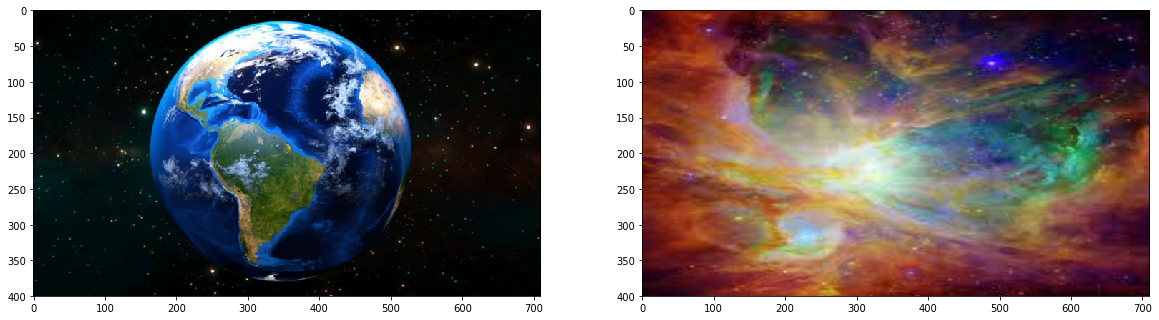

In [64]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

### Let's get our features for our images , here not all conv layers we need for extraction so according to the paper we have gotten only the features we need from specific layers.

In [0]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

### Here , we define our gram matrix , so that we are able to compute style losses for our style image.

In [0]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram

### Let's get our features from content and style from specific conv layers and calculate gram matrix for each layers defined above.
### Also we define our target image as clone of content image and setting required_grad = True will be needed to allow backpropogation and optimizer to reduce the loss and apply our styles.

In [0]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

### One of the important things is that when we need to add up the losses for style losses for each layers , then we set the weights because each layer extracts different kinds of features.
### Also we set content_weight and style_weight because both the losses are calculated in different ways and hence we required them to be balanced in respect to each other , and hence , we generally set content_weight (alpha) = 1 and set style_weight (beta) = high as described in the paper.

In [0]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

### Let's write our main loop which calculates each time the losses and then backpropogates and optimizes the target image to look more and more like our style image.

Total loss:  69065392.0


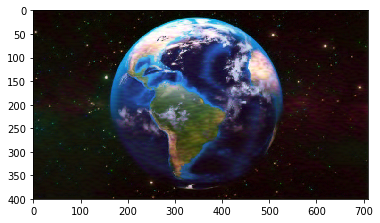

Total loss:  33623564.0


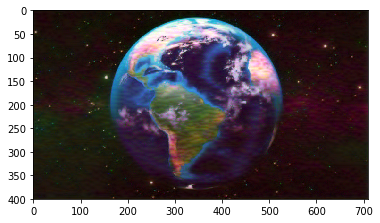

Total loss:  19201826.0


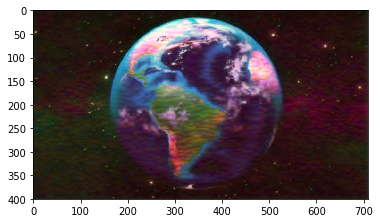

Total loss:  12133063.0


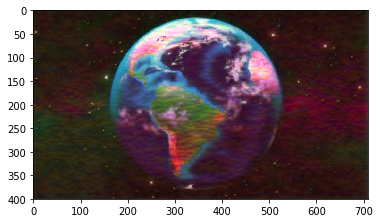

Total loss:  8172622.5


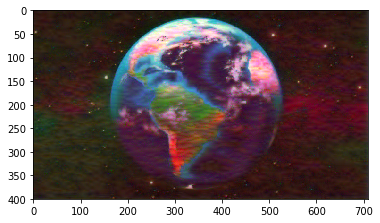

Total loss:  5739424.5


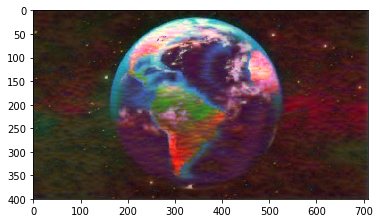

Total loss:  4146618.5


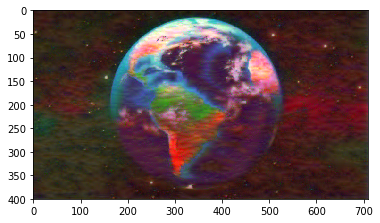

Total loss:  3081077.25


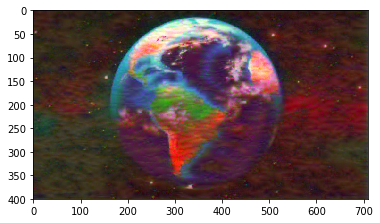

Total loss:  2365165.5


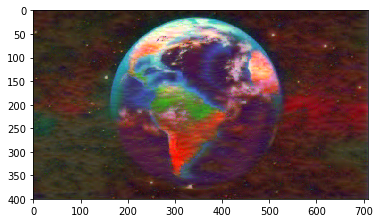

Total loss:  1878339.625


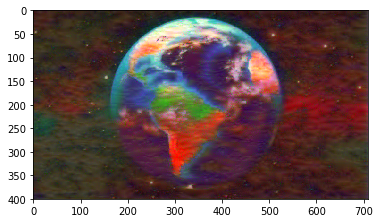

In [29]:
# for displaying the target image, intermittently
show_every = 200

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

### Let's check our final image (target output) after iterations produced through neural style transfer using Pytorch and VGG19 (pretrained models.)

Text(0.5, 1.0, 'target')

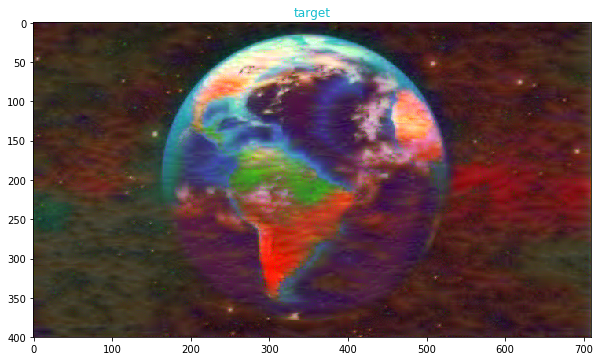

In [66]:
# display content and final, target image
# display the images
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(target))
ax1.set_title('target', color='C9')
